# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


In [24]:
# Loading model
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)],

In [1]:
# Reading the results file
from ema_workbench import load_results
file_name = 'selected_results.tar.gz'
results = load_results(file_name)
# Extracting experiment and outcomes from results
exp, outcomes = results

In [9]:
# Function to normailze the dictionary outcomes
def normalize_out_dic(outcomes):
    norm_outcomes = {}
    for ooi in outcomes.keys():
        data = outcomes[ooi]
        mx = max(data)
        mn = min(data)
        if mx == mn:
            norm_outcomes[ooi] = data - mn
        else:
            norm_outcomes[ooi] = (data - mn)/(mx-mn)
    return norm_outcomes


# Defining function for calculating distance and diversity of scenarios
def calculate_distance(data, oois, scenarios=None, distance='euclidean'):
    '''data is the outcomes of exploration results,
    scenarios is a list of scenario indices (decision variables), 
    oois is a list of variable names,
    distance is to choose the distance metric. options:
            bray-curtis, canberra, chebyshev, cityblock (manhattan), correlation, 
            cosine, euclidian, mahalanobis, minkowski, seuclidian,
            sqeuclidian, wminkowski
    returns a list of distance values
    '''
    #make a matrix of the data n_scenarios x oois
    scenario_data = np.zeros((len(scenarios), len(oois)))
    for i, s in enumerate(scenarios):
        for j, ooi in enumerate(oois):
            scenario_data[i][j] = data[ooi][s]
                
    distances = pdist(scenario_data, distance)
    return distances

# Function for calculating unique diversity 
def evaluate_diversity_single(x, data=norm_new_out, oois=oois, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    distances = calculate_distance(data, oois, list(x), distance)
    minimum = np.min(distances)
    mean = np.mean(distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]

# Function for finding maximum diverse scenarios
def find_maxdiverse_scenarios(combinations):
    diversity = 0.0
    solutions = []
    for sc_set in combinations:
        temp_div = evaluate_diversity_single(list(sc_set))
        if temp_div[0] > diversity:
            diversity = temp_div[0]
            solutions = []
            solutions.append(sc_set)
        elif temp_div[0] == diversity:
            solutions.append(sc_set)
    #print("found diversity ", diversity)
    return diversity, solutions

In [10]:
# Normailizing the outcomes
norm_new_out = normalize_out_dic(outcomes)

# creating a list of outcome variables (key of dictionary)
oois = list(outcomes.keys())

In [ ]:
# Number of scenarios = total number of unique outcome variables
n_scen = len(outcomes[oois[0]])
indices = range(n_scen)
set_size = 4
import itertools
# Making all the possible combinations of number of scenarios for desired number
combinations = itertools.combinations(indices, set_size)
# changing the type
combinations = list(combinations)

In [ ]:
no_workers = multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=no_workers)
    
    with open('output_scenarioselection_v3.txt', 'a') as file:
    
        start_time = time.time()
        #now, divide this data for each worker
        worker_data = np.array_split(combinations, no_workers)
               
        result = pool.imap(find_maxdiverse_scenarios, worker_data)
                
        #find the max of these 8 
        max_diversity = 0.0
        for r in result:
            print("result : ", r)
            if r[0] >= max_diversity:
                max_diversity = r[0]
                solutions = []
                solutions.append(r[1])
            elif r[0] == max_diversity:
                solutions.append(r[1])                  
  
        end_time = time.time()
        file.write("Calculations took {} seconds.\n".format(end_time-start_time))
        print("Calculations took {} seconds.\n".format(end_time-start_time))
        file.write("maximum diversity and solutions: {}, {} \n\n".format(max_diversity, solutions))
        print("maximum diversity and solutions: {}, {} \n\n".format(max_diversity, solutions))


    file.close()
        
    pool.close()
    pool.join()

In [12]:
# Selecting 4 random scenarios
import random
random_scenario=[]
for i in range(4):
    random_scenario.append(random.randint(0,len(exp)))
    
# Subsetting exp for randm scenarios
random_scenario = exp.iloc[random_scenario,:]

In [20]:
random_scenario

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
147,0.348439,0.930274,0.033661,4.152342,0.003432,0.253202,0.807776,0.269349,1.966118,0.354901,618,3,lakeproblem
498,0.361473,0.935603,0.043061,3.634113,0.001163,0.246458,0.308660,0.088750,1.902593,0.410787,948,28,lakeproblem
393,0.350349,0.940285,0.040494,3.967052,0.002574,0.253437,0.103156,0.280169,1.902593,0.392061,13,20,lakeproblem
419,0.264301,0.946028,0.037737,3.790340,0.002732,0.253437,0.103156,0.280169,1.902593,0.392061,549,20,lakeproblem


# Search for each scenario
For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small).

Store the resulting set of pareto solutions in a smart way for subsequent analysis.

In [21]:
# Defining scenarios
from ema_workbench import Scenario
reference1 = Scenario('reference1', b=0.348439, q=4.152342, mean=0.033661, stdev=0.003432)
reference2 = Scenario('reference1', b=0.361473, q=3.634113, mean=0.043061, stdev=0.001163)
reference3 = Scenario('reference1', b=0.350349, q=3.967052, mean=0.040494, stdev=0.002574)
reference4 = Scenario('reference1', b=0.264301, q=3.790340, mean=0.037737, stdev=0.002732)


In [25]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging,Constant)
# Running for selected randim scenario 1
with MultiprocessingEvaluator(lake_model) as evaluator:
    results1 = evaluator.optimize(searchover='levers', nfe=500, epsilons=[0.1, ]*4, reference=reference1)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


In [26]:
# Running for selected randim scenario 2
with MultiprocessingEvaluator(lake_model) as evaluator:
    results2 = evaluator.optimize(searchover='levers', nfe=500, epsilons=[0.1, ]*4, reference=reference2)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] optimization completed, found 3 solutions
[MainProcess/INFO] terminating pool


In [27]:
# Running for selected randim scenario 3
with MultiprocessingEvaluator(lake_model) as evaluator:
    results3 = evaluator.optimize(searchover='levers', nfe=500, epsilons=[0.1, ]*4, reference=reference3)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


In [28]:
# Running for selected randim scenario 4
with MultiprocessingEvaluator(lake_model) as evaluator:
    results4 = evaluator.optimize(searchover='levers', nfe=500, epsilons=[0.1, ]*4, reference=reference4)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/500 nfe
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool


In [29]:
# Combining all the results
result = results1
result = result.append(results2)
result = result.append(results3)
result = result.append(results4)

In [32]:
result

,l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,...,l93,l94,l95,l96,l97,l98,l99,max_P,utility,reliability
0,0.005580,0.088594,0.082526,0.041693,0.018183,0.087463,0.090196,0.022367,0.054696,0.092142,...,0.055079,0.021481,0.050579,0.034600,0.058389,0.042622,0.052673,0.297008,0.835069,1.0000
1,0.097781,0.077578,0.097183,0.023375,0.094263,0.093914,0.093667,0.090056,0.091185,0.051853,...,0.017521,0.032072,0.040576,0.017058,0.014306,0.085000,0.067086,0.387210,1.217091,1.0000
0,0.030952,0.080090,0.090818,0.072252,0.011029,0.053531,0.029415,0.012571,0.095620,0.010317,...,0.050024,0.066022,0.013882,0.027798,0.032559,0.098250,0.000069,0.289274,0.629193,1.0000
1,0.083248,0.096890,0.020807,0.083833,0.034276,0.062572,0.097438,0.022318,0.015965,0.094517,...,0.076360,0.088358,0.093574,0.039252,0.062030,0.083512,0.064261,0.396075,1.043803,1.0000
2,0.081615,0.085727,0.084928,0.076991,0.096740,0.044729,0.030743,0.043361,0.081481,0.094167,...,0.037562,0.048190,0.054198,0.090434,0.079683,0.081573,0.097693,0.434318,1.134566,1.0000
0,0.085767,0.055771,0.085482,0.067164,0.084389,0.093725,0.065096,0.003854,0.058917,0.024947,...,0.036444,0.044877,0.069924,0.024708,0.001974,0.091070,0.057541,0.395273,1.108781,1.0000
1,0.085767,0.057070,0.085482,0.067164,0.084389,0.093725,0.065096,0.028821,0.060018,0.096850,...,0.036444,0.043721,0.069924,0.024708,0.001961,0.091070,0.088577,0.432613,1.219280,1.0000
0,0.028389,0.037900,0.065469,0.092050,0.084501,0.023813,0.062768,0.069448,0.079823,0.081605,...,0.077230,0.081731,0.085904,0.018602,0.084300,0.075783,0.099927,4.191995,1.033747,0.2399
1,0.085660,0.036798,0.098692,0.006959,0.036048,0.097426,0.087192,0.011578,0.035544,0.063889,...,0.051680,0.016951,0.094101,0.023586,0.069648,0.070125,0.060096,4.223681,0.983519,0.3037
2,0.061816,0.039862,0.052754,0.040761,0.003520,0.080809,0.008204,0.053534,0.051169,0.007995,...,0.018703,0.004374,0.015519,0.060186,0.011421,0.070135,0.006314,4.093667,0.707482,0.5016


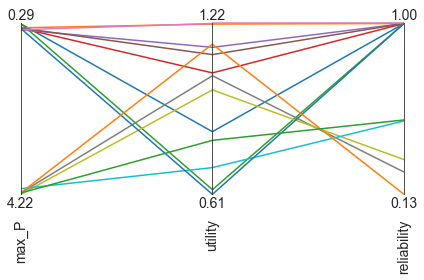

In [37]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords
outcomes = result.loc[:, ['max_P', 'utility', 'reliability']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?
